In [1]:
# !pip install livelossplot
from data_preprocessing import *
from data_visualisation import *
from cnn_evaluation import *

In [2]:
# import all relevant libraies needed for the model building and training.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras
# from tensorflow.keras.regularizers import L2

In [3]:
# mount the google drive.
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# unzip the archive file since we intend to use it.
# !unzip '/content/drive/MyDrive/archive.zip'

In [5]:
# define a function to preview the image.
def fix_image_path(dataset):
    """
    This function changes the path of both full mammogram, cropped and mask column.
    Args:
        dataset(dataframe): A dataframe containing the columns whose paths are to be fixed.
    """
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        dataset.iloc[i,11] = full_mammogram_dict[img_name]
        img_name = img[12].split("/")[2]
        dataset.iloc[i,12] = cropped_dict[img_name]
        img_name = img[13].split("/")[2]
        dataset.iloc[i,13] = masked_dict[img_name]

In [6]:
DICOM_PATH = "csv/dicom_info.csv"
CASE_TRAIN_PATH = "csv/calc_case_description_train_set.csv"
CASE_TEST_PATH = "csv/calc_case_description_test_set.csv"
MASS_TRAIN_PATH = "csv/mass_case_description_train_set.csv"
MASS_TEST_PATH = "csv/mass_case_description_test_set.csv"
# load the dicom data. The dicom holds meta info about the data including the file path which we would use.
dicom_data = data_loading(DICOM_PATH)
# load the case train and case test data.
case_train_data = data_loading(CASE_TRAIN_PATH)
case_test_data= data_loading(CASE_TEST_PATH)
# load the mass train and mass test data.
mass_train_data = data_loading(MASS_TRAIN_PATH)
mass_test_data = data_loading(MASS_TEST_PATH)

In [7]:
# define the image path.
image_dir = "jpeg"
# the dicom file contains full mammogram images, cropped images and roi images.
full_mammogram = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
masked_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path

# replace the image path to read from our own path.
full_mammogram = full_mammogram.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
masked_images = masked_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

In [8]:
full_mammogram_dict = dict()
cropped_dict = dict()
masked_dict = dict()

for dicom in full_mammogram:
    key = dicom.split("/")[1]
    full_mammogram_dict[key] = dicom

for dicom in cropped_images:
    key = dicom.split("/")[1]
    cropped_dict[key] = dicom

for dicom in masked_images:
    key = dicom.split("/")[1]
    masked_dict[key] = dicom

next(iter((full_mammogram_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 'jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [9]:
fix_image_path(mass_train_data)
fix_image_path(mass_test_data)

In [10]:
root_path = os.getcwd()
full_image_path = os.path.join(root_path, "full_image")
masked_path = os.path.join(root_path, "masked_image")
cropped_path = os.path.join(root_path, "cropped_image")
output_folder = os.path.join(root_path, "outputs")

# create all the directories.
create_new_directory(full_image_path)
create_new_directory(masked_path)
create_new_directory(cropped_path)
create_new_directory(output_folder)

The directory 'd:\stanley_dissertation\full_image' has been created or already exists.
The directory 'd:\stanley_dissertation\masked_image' has been created or already exists.
The directory 'd:\stanley_dissertation\cropped_image' has been created or already exists.
The directory 'd:\stanley_dissertation\outputs' has been created or already exists.


In [11]:
preprocessed_mass_train= mass_train_data[mass_train_data['pathology'] != "BENIGN_WITHOUT_CALLBACK"]
preprocessed_mass_test = mass_test_data[mass_test_data['pathology'] != "BENIGN_WITHOUT_CALLBACK"]
# append both data.
full_data = pd.concat([preprocessed_mass_train, preprocessed_mass_test], axis = 0)
CLASSIFICATION = {"BENIGN": 0, "MALIGNANT": 1}
# Create a new column 'classification' based on the 'pathology' column and the CLASSIFICATION dictionary
full_data['classification'] = full_data['pathology'].map(CLASSIFICATION)
full_data = full_data.sort_values(by='pathology')

In [12]:
# split the dataset into train, validation and test.
# first seperate the features from the labels.
X = full_data.drop(['classification'], axis=1)
Y = full_data['classification']

# show distribution of benign and malignant here.
# plot the distribution at this point.
show_bar_plot(full_data, output_folder, "cancer_distr_before_split")

In [14]:
# show the percentage.
show_pie_plot(full_data, output_folder, "cancer_distr_before_split_pie")

In [16]:
# create the train, validation and test directory for malignant and benign cases for both full, cropped and masked image.
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 123, stratify = Y)
# still split the X_train and Y_train into train and validation.
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 123, stratify = Y_train)
# show distribution of benign and malignant here.
# plot the distribution at this point.

In [17]:
# plot the distribution at this point.
show_bar_plot(X_train, output_folder, "cancer_distr_train")

In [18]:
# plot the distribution at this point.
show_bar_plot(X_valid, output_folder, "cancer_distr_valid")

In [19]:
# plot the distribution at this point.
show_bar_plot(X_test, output_folder, "cancer_distr_test")

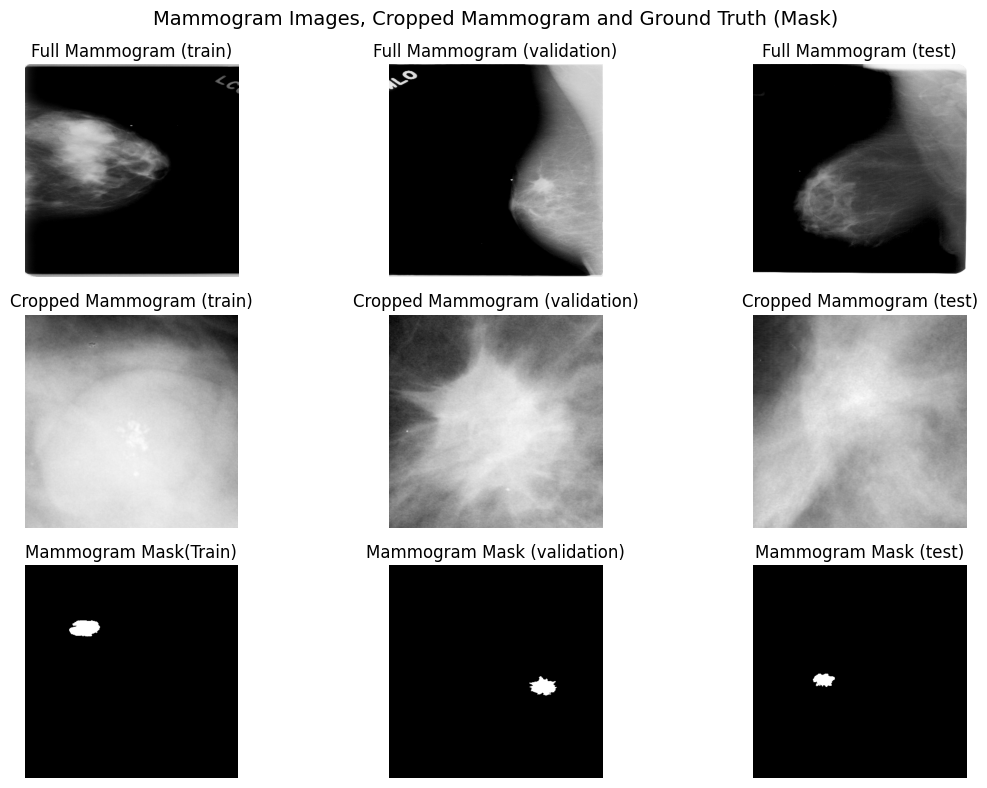

In [21]:
# Plot the image

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,8))
show_image(ax[0,0],X_train.iloc[2]['image file path'], "Full Mammogram (train)")
show_image(ax[0,1],X_valid.iloc[2]['image file path'], "Full Mammogram (validation)")
show_image(ax[0,2],X_test.iloc[2]['image file path'], "Full Mammogram (test)")

show_image(ax[1,0],X_train.iloc[2]['cropped image file path'], "Cropped Mammogram (train)")
show_image(ax[1,1],X_valid.iloc[2]['cropped image file path'], "Cropped Mammogram (validation)")
show_image(ax[1,2],X_test.iloc[2]['cropped image file path'], "Cropped Mammogram (test)")

show_image_roi(ax[2,0],X_train.iloc[2]['ROI mask file path'], "Mammogram Mask(Train)")
show_image_roi(ax[2,1],X_valid.iloc[2]['ROI mask file path'], "Mammogram Mask (validation)")
show_image_roi(ax[2,2],X_test.iloc[2]['ROI mask file path'], "Mammogram Mask (test)")

plt.suptitle("Mammogram Images, Cropped Mammogram and Ground Truth (Mask)", fontsize="14")
plt.tight_layout()
plt.savefig(os.path.join(output_folder,"images.png"))
plt.show()


In [22]:
# full, crop and mask train and test directories.
full_benign_train_directory = os.path.join(full_image_path, "train", "benign")
full_malignant_train_directory = os.path.join(full_image_path, "train", "malignant")
# for the valid.
full_benign_valid_directory = os.path.join(full_image_path, "valid", "benign")
full_malignant_valid_directory = os.path.join(full_image_path, "valid", "malignant")
# for the test.
full_benign_test_directory = os.path.join(full_image_path, "test", "benign")
full_malignant_test_directory = os.path.join(full_image_path, "test", "malignant")

#############################################################################################
# mask train , valid and test directories.
mask_benign_train_directory = os.path.join(masked_path, "train", "benign")
mask_malignant_train_directory = os.path.join(masked_path, "train", "malignant")
# for the valid.
mask_benign_valid_directory = os.path.join(masked_path, "valid", "benign")
mask_malignant_valid_directory = os.path.join(masked_path, "valid", "malignant")
# for the test.
mask_benign_test_directory = os.path.join(masked_path, "test", "benign")
mask_malignant_test_directory = os.path.join(masked_path, "test", "malignant")

#############################################################################################
# cropped train, valid and test directories.
cropped_benign_train_directory = os.path.join(cropped_path, "train", "benign")
cropped_malignant_train_directory = os.path.join(cropped_path, "train", "malignant")
# for the valid.
cropped_benign_valid_directory = os.path.join(cropped_path, "valid", "benign")
cropped_malignant_valid_directory = os.path.join(cropped_path, "valid", "malignant")
# for the test.
cropped_benign_test_directory = os.path.join(cropped_path, "test", "benign")
cropped_malignant_test_directory = os.path.join(cropped_path, "test", "malignant")

# create all the directories.
# for full_images
create_new_directory(full_benign_train_directory)
create_new_directory(full_malignant_train_directory)
create_new_directory(full_benign_valid_directory)
create_new_directory(full_malignant_valid_directory)
create_new_directory(full_benign_test_directory)
create_new_directory(full_malignant_test_directory)
# for masked_images
create_new_directory(mask_benign_train_directory)
create_new_directory(mask_malignant_train_directory)
create_new_directory(mask_benign_valid_directory)
create_new_directory(mask_malignant_valid_directory)
create_new_directory(mask_benign_test_directory)
create_new_directory(mask_malignant_test_directory)
# for cropped_images
create_new_directory(cropped_benign_train_directory)
create_new_directory(cropped_malignant_train_directory)
create_new_directory(cropped_benign_valid_directory)
create_new_directory(cropped_malignant_valid_directory)
create_new_directory(cropped_benign_test_directory)
create_new_directory(cropped_malignant_test_directory)

The directory 'd:\stanley_dissertation\full_image\train\benign' has been created or already exists.
The directory 'd:\stanley_dissertation\full_image\train\malignant' has been created or already exists.
The directory 'd:\stanley_dissertation\full_image\valid\benign' has been created or already exists.
The directory 'd:\stanley_dissertation\full_image\valid\malignant' has been created or already exists.
The directory 'd:\stanley_dissertation\full_image\test\benign' has been created or already exists.
The directory 'd:\stanley_dissertation\full_image\test\malignant' has been created or already exists.
The directory 'd:\stanley_dissertation\masked_image\train\benign' has been created or already exists.
The directory 'd:\stanley_dissertation\masked_image\train\malignant' has been created or already exists.
The directory 'd:\stanley_dissertation\masked_image\valid\benign' has been created or already exists.
The directory 'd:\stanley_dissertation\masked_image\valid\malignant' has been create

In [23]:
# full train images.
create_save_full_images(X_train[X_train['pathology'] == 'BENIGN'], full_benign_train_directory, "B")
create_save_full_images(X_train[X_train['pathology'] == 'MALIGNANT'], full_malignant_train_directory, "M")
# mask train images.
create_save_mask_images(X_train[X_train['pathology'] == 'BENIGN'], mask_benign_train_directory, "B")
create_save_mask_images(X_train[X_train['pathology'] == 'MALIGNANT'], mask_malignant_train_directory, "M")
# crop train images
create_save_cropped_images(X_train[X_train['pathology'] == 'BENIGN'], cropped_benign_train_directory, "B")
create_save_cropped_images(X_train[X_train['pathology'] == 'MALIGNANT'], cropped_malignant_train_directory, "M")


In [24]:
# full valid images.
create_save_full_images(X_valid[X_valid['pathology'] == 'BENIGN'], full_benign_valid_directory, "B")
create_save_full_images(X_valid[X_valid['pathology'] == 'MALIGNANT'], full_malignant_valid_directory, "M")
# mask valid images.
create_save_mask_images(X_valid[X_valid['pathology'] == 'BENIGN'], mask_benign_valid_directory, "B")
create_save_mask_images(X_valid[X_valid['pathology'] == 'MALIGNANT'], mask_malignant_valid_directory, "M")
# crop valid images
create_save_cropped_images(X_valid[X_valid['pathology'] == 'BENIGN'], cropped_benign_valid_directory, "B")
create_save_cropped_images(X_valid[X_valid['pathology'] == 'MALIGNANT'], cropped_malignant_valid_directory, "M")

In [25]:
# full test images.
create_save_full_images(X_test[X_test['pathology'] == 'BENIGN'], full_benign_test_directory, "B")
create_save_full_images(X_test[X_test['pathology'] == 'MALIGNANT'], full_malignant_test_directory, "M")
# mask test images.
create_save_mask_images(X_test[X_test['pathology'] == 'BENIGN'], mask_benign_test_directory, "B")
create_save_mask_images(X_test[X_test['pathology'] == 'MALIGNANT'], mask_malignant_test_directory, "M")
# crop test images
create_save_cropped_images(X_test[X_test['pathology'] == 'BENIGN'], cropped_benign_test_directory, "B")
create_save_cropped_images(X_test[X_test['pathology'] == 'MALIGNANT'], cropped_malignant_test_directory, "M")

In [26]:
# start performing Data Augmentation.
# source: modified from: https://stackoverflow.com/questions/58050113/imagedatagenerator-for-semantic-segmentation

train_datagen = ImageDataGenerator(
    # preprocessing_function = preprocess_input,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    height_shift_range=0.5,
)

valid_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [27]:
seed = 123 # to transform image and corresponding mask with same augmentation parameter.
IMG_SIZE = (224, 224)
batch_size = 32

train_image_generator = train_datagen.flow_from_directory(
    os.path.join(full_image_path, "train"),
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_image_generator = valid_datagen.flow_from_directory(
    os.path.join(full_image_path, "valid"),
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

train_mask_generator = train_datagen.flow_from_directory(
    os.path.join(masked_path, "train"),
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

valid_mask_generator = valid_datagen.flow_from_directory(
    os.path.join(masked_path, "valid"),
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 1028 images belonging to 2 classes.
Found 278 images belonging to 2 classes.
Found 1028 images belonging to 2 classes.
Found 278 images belonging to 2 classes.


In [ ]:
Y_train = to_categorical(Y_train, num_classes = 2)

In [28]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape = (224, 224, 3))

In [29]:
# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [30]:
breast_cnn = new_model(base_model, seed, 0.5)

In [31]:
breast_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
breast_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(),
                   metrics=['accuracy', f1_score])

In [ ]:
model_path_disc = os.path.join(root_path, "learning.h5")

callbacks = [
    ModelCheckpoint(model_path_disc, verbose=2, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    PlotLossesKeras()
]
num_epochs = 150

history = breast_cnn.fit(
    train_image_generator,
    epochs=num_epochs,
    steps_per_epoch=train_image_generator.samples // batch_size,
    validation_data=valid_image_generator,
    validation_steps=valid_image_generator.samples // batch_size,
    callbacks=callbacks
)

In [32]:
import pickle


In [ ]:
train_generator = learned_model.evaluate(train_image_generator)

In [ ]:
test_image_generator = valid_datagen.flow_from_directory(
    os.path.join(full_image_path, "test"),
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
test_result = learned_model.evaluate(test_image_generator)

In [ ]:
validation = learned_model.evaluate(valid_image_generator)

In [ ]:
!pip install lime

In [ ]:
from lime.lime_image import LimeImageExplainer
explainer = LimeImageExplainer()

In [ ]:
import cv2

# Load the image using OpenCV
image = cv2.imread(os.path.join(full_benign_train_directory, "image_B1001.jpg"))

# Check if the image was loaded successfully
if image is not None:
    # Resize the image to 224x224
    resized_image = cv2.resize(image, (224, 224))
else:
    print("Image not found or unable to load.")

In [ ]:
print(resized_image)

In [ ]:
explanation = explainer.explain_instance(resized_image, learned_model.predict, top_labels = 1, num_samples=1000)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest= False)

In [ ]:
from lime import lime_image
import matplotlib.pyplot as plt

# Assuming 'mask' is your LIME mask (grayscale)
# You can adapt it to an RGB image for visualization
normalized_mask = ((mask - np.min(mask)) / (np.max(mask) - np.min(mask)) * 255).astype(np.uint8)

# Create an empty RGB image with the same shape as the mask
rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

# Set the red channel to the normalized mask values
rgb_mask[:, :, 0] = normalized_mask

# Display the RGB mask
plt.imshow(rgb_mask)
plt.axis('off')
plt.show()